In [4]:
#1) Import libraries
from qpsolvers import solve_qp
import time
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import Environments
import pandas as pd

In [5]:
#2) Create functions for quadratic computing
def H_funct(n):
    # H = np.zeros((3*n,3*n))
    H = np.diag([1e-5]*(3*n))
    for i in range(n):
        H[i*3+1,i*3+1] = 1.
    return H

def Q_funct(n,vd):
    Q = np.zeros((3*n,))
    for i in range(n):
        Q[i*3+1]=-vd
    return Q

def A2_funct(n,dt):
    A = np.zeros((2*n+1,3*n))
    for i in range(0,2):
        A[i,i]=1.
        A[i+2*(n-1),i+2*(n-1)+(n-1)]=0
    for i in range(2,2*n):
        j=i+(i//2)
        #if(i<2*(n-1)):
        A[i,j]=-1.
        A[i,j-3]=1.
        A[i,j-2]=dt
        if(i%2==0): 
            A[i,j-1]=dt**2 /2.
    for i in range(2*n,2*n+1):
        j=i+(i//2)-3
        A[i,j]=1.
    return A

def A_funct(n,dt):
    A = np.zeros((2*n+1,3*n))
    for i in range(0,2):
        A[i,i]=1.
        A[i+2*(n-1),i+2*(n-1)+(n-1)]=0.
    for i in range(2,2*n):
        j=i+(i//2)
        #if(i<2*(n-1)):
        A[i,j]=-1.
        A[i,j-3]=1.
        A[i,j-2]=dt
        if(i%2==0): 
            A[i,j-1]=dt**2 /2.
    for i in range(2*n,2*n+1):
        j=i+(i//2)-3
        A[i,j+1]=1
    return A

def B2_funct(n,xi,xf):
    B = np.zeros((2*n+1,))
    B[0]=xi[0]
    B[1]=xi[1]
    B[2*n]=xf[0]
   # B[2*n+1]=xf[1]
    return B

def B_funct(n,xi,xf):
    B = np.zeros((2*n+1,))
    B[0]=xi[0]
    B[1]=xi[1]
    #B[2*n]=xf[0]
    B[2*n]=xf[1]
    return B

def bounds(n,bds):
    bounds= np.zeros((3*n))
    for i in range(n):
        bounds[i*3:i*3+3]=bds
    return bounds


In [6]:
#3) Quadratic programming model
class Model_QP():
    """
        Class: select action
        :param dt: time step
        :param lb: lower bounds [position, speed, acceleration]
        :param ub: upper bounds [position, speed, acceleration]
    """
    def __init__(self, dt, lb, ub):
        self.dt = dt
        self.lb = lb
        self.ub = ub
        
    def new_action_position(self, n, x_init, x_final):
        """
        New action : 
        :param n: number of steps
        :param x_init: initial position & speed
        :param x_final: final position & speed
        :return: [position, speed, acceleration]
        """ 
        H=H_funct(n)
        q=Q_funct(n,x_final[1])
        A=A2_funct(n,self.dt)
        B=B2_funct(n,x_init,x_final)
        lbs=bounds(n,self.lb)
        ubs=bounds(n,self.ub)
        return solve_qp(H, q, A=A, b=B, lb=lbs, ub=ubs)
    
    def new_action_speed(self, n, x_init, x_final):
        """
        New action : 
        :param n: number of steps
        :param x_init: initial position & speed
        :param x_final: final position & speed
        :return: [position, speed, acceleration]
        """ 
        H=H_funct(n)
        q=Q_funct(n,x_final[1])
        A=A_funct(n,self.dt)
        B=B_funct(n,x_init,x_final)
        lbs=bounds(n,self.lb)
        ubs=bounds(n,self.ub)
        return solve_qp(H, q, A=A, b=B, lb=lbs, ub=ubs)

In [85]:
#4) Rollout on the environment:
class Env_rollout:
    """ 
        Class : iterate on the environment
        :param env: our environment
        :param max_steps: max steps per episode
        :param dt: time step
        :param cross: size crosswalk
        :param acc_max: maximal acceleration
        :param acc_min: minimal acceleration
        :param tau: reaction time
    """
    def __init__(self, env, max_steps, dt, cross, acc_max, acc_min, tau):
        self.env = env
        self.max_steps = max_steps
        self.dt = dt
        self.cross = cross
        self.prev_state = env.reset()
        self.acc_max=acc_max
        self.acc_min=acc_min
        self.tau=tau
        
    
    def delta_l(self, x, v):
        """
        Compute safety factor
        :param x: distance between the car and the crosswalk (negative value) 
        :param v: vehicle speed
        :return: safety factor
        """    
        return -x - (v * v / (-2.0 * self.acc_min) + self.tau * v)
    
    def tranformation_action(self,value):
        """
        Transform the value for environment (before step iteration)
        :param value: element compute with QP
        :return: transformed value
        """  
        a=2./(self.acc_max-self.acc_min)
        b=-(self.acc_max+self.acc_min)/(self.acc_max-self.acc_min)
        return a*value+b
    
    def iterations(self, model, nbr_episodes):
        """
        Iterate on the environment.
        :param model: current policy
        :param nbr_episodes: episode number
        :return: Tensors; state batch, action batch, reward batch
        """
        batch_obs=[]
        batch_acts=[]
        batch_rews=[]
        for ep in range(nbr_episodes):
            prev_state = env.reset()
            self.ds=prev_state[1]
            self.ped_speed=prev_state[3]
            self.choice_car=(self.delta_l(prev_state[2], prev_state[1]) >= 0)
            for step_ep in range(self.max_steps):
                car_parameters=[0., 0., 0.]
                initial_state = prev_state[1:3][1::-1]
                if(prev_state[2]>=0. or prev_state[4]>=self.cross): # if car already pass the crosswalk
                    n=1+math.ceil((self.ds-prev_state[1])/(self.dt*self.acc_max))
                    if(self.ds-prev_state[1]>0.):
                        final_state = [prev_state[2]+n*self.ds*self.dt, self.ds]
                        car_parameters = model.new_action_speed(n, initial_state, final_state)
                        if(car_parameters is None):
                            car_parameters=[0., 0., prev_state[0]+0.1]
                else:
                    if(prev_state[1]<0.0):
                        car_parameters=[0., 0., 0.2]
                    elif(prev_state[3]<0.1):
                        final_state = [0., self.ds]
                        car_parameters = model.new_action_position(8, initial_state, final_state)
                        while(car_parameters is None and n<20):
                            car_parameters = model.new_action_position(n, initial_state, final_state)
                            n=n+1
                        if(car_parameters is None):
                            car_parameters=[0., 0., self.acc_min]
                    else:
                        n=4+math.ceil((self.cross-prev_state[4])/(self.dt*self.ped_speed))
                        if(n==2):
                            acc=-2.*(prev_state[1]*self.dt + prev_state[2])/(self.dt**2)
                            car_parameters=[0., 0., acc]
                        if(n>2):
                            final_state = [0., self.ds]
                            car_parameters = model.new_action_position(n, initial_state, final_state)
                            while(car_parameters is None and n<8):
                                car_parameters = model.new_action_position(n, initial_state, final_state)
                                n=n+1
                            if(car_parameters is None):
                                car_parameters=[0., 0., prev_state[0]+0.2]
                if(not self.choice_car):
                    car_parameters=[0., 0., 0.]
                action=self.tranformation_action(car_parameters[2])
                state, reward, done, _ = self.env.step(np.clip([action],-1.0,1.0))
                batch_obs.append(prev_state)
                batch_acts.append(car_parameters[2])
                batch_rews.append(reward)
                prev_state = state
                if done:
                    break
            avg_reward = np.mean(batch_rews[-10:])
            print("Episode * {} * Avg Reward is ==> {} And Number of steps is ==> {}".format(ep, avg_reward,ep))
        return batch_obs, batch_acts, batch_rews

In [86]:
#4) QP Algorithm:
class Algo_QP():
    """ 
    QP algorithm : testing
    :param policy_class: policy
    :param env: environment
    :param hyperparameters: other hyperparameters
    """
    def __init__(self, policy_class, env, **hyperparameters):
        
        self._init_hyperparameters(hyperparameters)
        self.model = policy_class(self.dt, self.l_b, self.u_b)
        self.rollout = Env_rollout(env, self.max_steps, self.dt, self.cross,self.u_b[2], self.l_b[2], self.tau)
    
    def evaluate(self, nbr_episodes):
        """
        Testing
        :param nbr_episodes: episode number 
        :return: state batch, action batch, and reward batch
        """
        state_batch, action_batch, rewards_batch = self.rollout.iterations(self.model, nbr_episodes)
        return state_batch, action_batch, rewards_batch
    
    def _init_hyperparameters(self, hyperparameters):
        """
        Initialize hyperparameters. 
        :param hyperparameters: hyperparameter list
        """
        for param, val in hyperparameters.items():
            exec('self.' + param + ' = ' + str(val))
        self.num_algo = 1
        self.max_steps = 90
        self.total_loop = 0
        self.dt = 0.3
        self.cross = 5.0
            

In [87]:
#5) Computing part:
# Import environment
problem = "Crosswalk_comparison-v0"
u_b = [2.0, 11.0, -12.5, 1.1, -1.0]
l_b = [-4.0, 9.0, -32.5, 0.9, -2.0]

env = gym.make(problem,dt=0.3,Vm=2.5,tau=1.0,lower_bounds=l_b, upper_bounds=u_b,simulation="sin")

# Initialize the algorithm
num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
num_algo=1
u_b2=[200.0,15.0,2.0]
l_b2=[-45.0,0.0,-4.0]
algo=Algo_QP(Model_QP, env, num_algo= num_algo, num_states=num_states, num_actions=num_actions,l_b=l_b2, u_b=u_b2, tau=1.0)
#algo.loading(1,1000)

C:\Users\abrunoud\Anaconda3\envs\ppotest\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [97]:
#Stock an evaluation sample
states, actions, rewards = algo.evaluate(2000)
states=np.array(states)
ep_action=states[:,0]
ep_speed_car=states[:,1]
ep_pos_car=states[:,2]
ep_speed_ped=states[:,3]
ep_pos_ped=states[:,4]
ep_time=states[:,9]
ep_reward=rewards
t=0

Episode * 0 * Avg Reward is ==> 0.9389473151209197 And Number of steps is ==> 0
Episode * 1 * Avg Reward is ==> 0.7371145260480482 And Number of steps is ==> 1
Episode * 2 * Avg Reward is ==> 1.3385645217146371 And Number of steps is ==> 2
Episode * 3 * Avg Reward is ==> 1.0384596686712075 And Number of steps is ==> 3
Episode * 4 * Avg Reward is ==> -3.6160710644197254 And Number of steps is ==> 4
Episode * 5 * Avg Reward is ==> -3.5 And Number of steps is ==> 5
Episode * 6 * Avg Reward is ==> 0.8077941645223303 And Number of steps is ==> 6
Episode * 7 * Avg Reward is ==> -3.66396945518908 And Number of steps is ==> 7
Episode * 8 * Avg Reward is ==> 0.7790534956016382 And Number of steps is ==> 8
Episode * 9 * Avg Reward is ==> -3.611048220130723 And Number of steps is ==> 9
Episode * 10 * Avg Reward is ==> -3.6610500314626804 And Number of steps is ==> 10
Episode * 11 * Avg Reward is ==> 0.9240509094447541 And Number of steps is ==> 11
Episode * 12 * Avg Reward is ==> -3.9169175984212

Episode * 103 * Avg Reward is ==> 0.7800482798429109 And Number of steps is ==> 103
Episode * 104 * Avg Reward is ==> 0.7454058780805941 And Number of steps is ==> 104
Episode * 105 * Avg Reward is ==> -3.5523740942126025 And Number of steps is ==> 105
Episode * 106 * Avg Reward is ==> -3.5 And Number of steps is ==> 106
Episode * 107 * Avg Reward is ==> 0.42840162967594553 And Number of steps is ==> 107
Episode * 108 * Avg Reward is ==> -3.6642346100345113 And Number of steps is ==> 108
Episode * 109 * Avg Reward is ==> 0.8217481668145641 And Number of steps is ==> 109
Episode * 110 * Avg Reward is ==> 1.1116413834840544 And Number of steps is ==> 110
Episode * 111 * Avg Reward is ==> 0.7635993780866455 And Number of steps is ==> 111
Episode * 112 * Avg Reward is ==> 0.8398996192332454 And Number of steps is ==> 112
Episode * 113 * Avg Reward is ==> -1.0365290724596972 And Number of steps is ==> 113
Episode * 114 * Avg Reward is ==> -3.663331612249498 And Number of steps is ==> 114
Ep

Episode * 208 * Avg Reward is ==> -3.6114871563613407 And Number of steps is ==> 208
Episode * 209 * Avg Reward is ==> 0.8478865914902676 And Number of steps is ==> 209
Episode * 210 * Avg Reward is ==> 0.8302653015471038 And Number of steps is ==> 210
Episode * 211 * Avg Reward is ==> 0.7856473315290492 And Number of steps is ==> 211
Episode * 212 * Avg Reward is ==> 0.8586697964117309 And Number of steps is ==> 212
Episode * 213 * Avg Reward is ==> 0.12332833728643991 And Number of steps is ==> 213
Episode * 214 * Avg Reward is ==> 1.3399055033644522 And Number of steps is ==> 214
Episode * 215 * Avg Reward is ==> 1.0793680710377078 And Number of steps is ==> 215
Episode * 216 * Avg Reward is ==> 0.7851962064262252 And Number of steps is ==> 216
Episode * 217 * Avg Reward is ==> 0.7369578876927386 And Number of steps is ==> 217
Episode * 218 * Avg Reward is ==> 0.7790912937965815 And Number of steps is ==> 218
Episode * 219 * Avg Reward is ==> -3.5677831034311582 And Number of steps 

Episode * 312 * Avg Reward is ==> 1.3382390774912665 And Number of steps is ==> 312
Episode * 313 * Avg Reward is ==> -3.9623462611789053 And Number of steps is ==> 313
Episode * 314 * Avg Reward is ==> -1.1215262036870643 And Number of steps is ==> 314
Episode * 315 * Avg Reward is ==> 0.9204392775633796 And Number of steps is ==> 315
Episode * 316 * Avg Reward is ==> -3.6192139404613526 And Number of steps is ==> 316
Episode * 317 * Avg Reward is ==> 0.799549715964716 And Number of steps is ==> 317
Episode * 318 * Avg Reward is ==> 1.0383994459247732 And Number of steps is ==> 318
Episode * 319 * Avg Reward is ==> 1.0387223540942823 And Number of steps is ==> 319
Episode * 320 * Avg Reward is ==> -3.5000000000000013 And Number of steps is ==> 320
Episode * 321 * Avg Reward is ==> -3.610060031993927 And Number of steps is ==> 321
Episode * 322 * Avg Reward is ==> -3.557123856559703 And Number of steps is ==> 322
Episode * 323 * Avg Reward is ==> -0.18411801506505512 And Number of step

Episode * 410 * Avg Reward is ==> -3.9622038831446758 And Number of steps is ==> 410
Episode * 411 * Avg Reward is ==> -3.6663459571801766 And Number of steps is ==> 411
Episode * 412 * Avg Reward is ==> -3.616626209320755 And Number of steps is ==> 412
Episode * 413 * Avg Reward is ==> 0.8677764219003207 And Number of steps is ==> 413
Episode * 414 * Avg Reward is ==> 1.0512613268869981 And Number of steps is ==> 414
Episode * 415 * Avg Reward is ==> -3.6660699568373607 And Number of steps is ==> 415
Episode * 416 * Avg Reward is ==> 0.7447352885583851 And Number of steps is ==> 416
Episode * 417 * Avg Reward is ==> 0.7359998964287313 And Number of steps is ==> 417
Episode * 418 * Avg Reward is ==> 0.853505494442599 And Number of steps is ==> 418
Episode * 419 * Avg Reward is ==> 0.8770546504046752 And Number of steps is ==> 419
Episode * 420 * Avg Reward is ==> 0.7611266404326861 And Number of steps is ==> 420
Episode * 421 * Avg Reward is ==> 0.7336549062665683 And Number of steps i

Episode * 514 * Avg Reward is ==> 0.8081899744756169 And Number of steps is ==> 514
Episode * 515 * Avg Reward is ==> -3.611940976154911 And Number of steps is ==> 515
Episode * 516 * Avg Reward is ==> 0.8412547562539778 And Number of steps is ==> 516
Episode * 517 * Avg Reward is ==> 1.0351216086704373 And Number of steps is ==> 517
Episode * 518 * Avg Reward is ==> -3.610059941205228 And Number of steps is ==> 518
Episode * 519 * Avg Reward is ==> 0.7549641011493265 And Number of steps is ==> 519
Episode * 520 * Avg Reward is ==> -3.6151956971426626 And Number of steps is ==> 520
Episode * 521 * Avg Reward is ==> -3.556924654692336 And Number of steps is ==> 521
Episode * 522 * Avg Reward is ==> -0.06754306066343416 And Number of steps is ==> 522
Episode * 523 * Avg Reward is ==> 1.389771329911746 And Number of steps is ==> 523
Episode * 524 * Avg Reward is ==> 0.8428355988767049 And Number of steps is ==> 524
Episode * 525 * Avg Reward is ==> 0.7943755039044313 And Number of steps i

Episode * 612 * Avg Reward is ==> 0.9474521538045533 And Number of steps is ==> 612
Episode * 613 * Avg Reward is ==> 1.4999999999999996 And Number of steps is ==> 613
Episode * 614 * Avg Reward is ==> 1.3372165797940099 And Number of steps is ==> 614
Episode * 615 * Avg Reward is ==> 0.8214085931490397 And Number of steps is ==> 615
Episode * 616 * Avg Reward is ==> 0.8238717296826599 And Number of steps is ==> 616
Episode * 617 * Avg Reward is ==> 1.3358788407833555 And Number of steps is ==> 617
Episode * 618 * Avg Reward is ==> 0.9856402236448236 And Number of steps is ==> 618
Episode * 619 * Avg Reward is ==> 0.7935487398473224 And Number of steps is ==> 619
Episode * 620 * Avg Reward is ==> 0.8387172864170769 And Number of steps is ==> 620
Episode * 621 * Avg Reward is ==> -3.5668007037888465 And Number of steps is ==> 621
Episode * 622 * Avg Reward is ==> 1.337038031760553 And Number of steps is ==> 622
Episode * 623 * Avg Reward is ==> 0.7695425876031756 And Number of steps is 

Episode * 711 * Avg Reward is ==> 0.7365685277924052 And Number of steps is ==> 711
Episode * 712 * Avg Reward is ==> 0.7503538198207467 And Number of steps is ==> 712
Episode * 713 * Avg Reward is ==> 0.8833086068993226 And Number of steps is ==> 713
Episode * 714 * Avg Reward is ==> 0.7368187032250436 And Number of steps is ==> 714
Episode * 715 * Avg Reward is ==> -3.6173709574496646 And Number of steps is ==> 715
Episode * 716 * Avg Reward is ==> 1.0389275741098103 And Number of steps is ==> 716
Episode * 717 * Avg Reward is ==> -3.660999240676408 And Number of steps is ==> 717
Episode * 718 * Avg Reward is ==> 0.7480397097886753 And Number of steps is ==> 718
Episode * 719 * Avg Reward is ==> 0.802407893427282 And Number of steps is ==> 719
Episode * 720 * Avg Reward is ==> 0.7747366811437498 And Number of steps is ==> 720
Episode * 721 * Avg Reward is ==> 1.0153025713741184 And Number of steps is ==> 721
Episode * 722 * Avg Reward is ==> 0.8802688409321426 And Number of steps is 

Episode * 816 * Avg Reward is ==> 0.7599583841944251 And Number of steps is ==> 816
Episode * 817 * Avg Reward is ==> -3.619060310120149 And Number of steps is ==> 817
Episode * 818 * Avg Reward is ==> 1.0369462063451198 And Number of steps is ==> 818
Episode * 819 * Avg Reward is ==> -0.7193260222975543 And Number of steps is ==> 819
Episode * 820 * Avg Reward is ==> 1.0386925569806578 And Number of steps is ==> 820
Episode * 821 * Avg Reward is ==> 0.7779700186869382 And Number of steps is ==> 821
Episode * 822 * Avg Reward is ==> 0.04776966660772053 And Number of steps is ==> 822
Episode * 823 * Avg Reward is ==> 0.852704168913189 And Number of steps is ==> 823
Episode * 824 * Avg Reward is ==> 0.8418942570921153 And Number of steps is ==> 824
Episode * 825 * Avg Reward is ==> 0.8517438299793106 And Number of steps is ==> 825
Episode * 826 * Avg Reward is ==> 0.848212877052832 And Number of steps is ==> 826
Episode * 827 * Avg Reward is ==> 0.8388226659184813 And Number of steps is 

Episode * 921 * Avg Reward is ==> -3.660275310646675 And Number of steps is ==> 921
Episode * 922 * Avg Reward is ==> 0.7351751545484959 And Number of steps is ==> 922
Episode * 923 * Avg Reward is ==> 0.8341236090319463 And Number of steps is ==> 923
Episode * 924 * Avg Reward is ==> -3.5 And Number of steps is ==> 924
Episode * 925 * Avg Reward is ==> 0.7847054226111136 And Number of steps is ==> 925
Episode * 926 * Avg Reward is ==> -3.9195880268882832 And Number of steps is ==> 926
Episode * 927 * Avg Reward is ==> 1.079979850319823 And Number of steps is ==> 927
Episode * 928 * Avg Reward is ==> 0.8527151216304091 And Number of steps is ==> 928
Episode * 929 * Avg Reward is ==> 0.8426995007930355 And Number of steps is ==> 929
Episode * 930 * Avg Reward is ==> -3.5521241841918183 And Number of steps is ==> 930
Episode * 931 * Avg Reward is ==> 0.7565920098016139 And Number of steps is ==> 931
Episode * 932 * Avg Reward is ==> 0.7626019891829208 And Number of steps is ==> 932
Episo

Episode * 1024 * Avg Reward is ==> 0.7320670131064854 And Number of steps is ==> 1024
Episode * 1025 * Avg Reward is ==> 1.0390948600555718 And Number of steps is ==> 1025
Episode * 1026 * Avg Reward is ==> -3.6661971139733813 And Number of steps is ==> 1026
Episode * 1027 * Avg Reward is ==> 0.7738408190092889 And Number of steps is ==> 1027
Episode * 1028 * Avg Reward is ==> 1.0806389654661266 And Number of steps is ==> 1028
Episode * 1029 * Avg Reward is ==> -3.6618823471530506 And Number of steps is ==> 1029
Episode * 1030 * Avg Reward is ==> 0.7670810640066422 And Number of steps is ==> 1030
Episode * 1031 * Avg Reward is ==> -3.558875906707544 And Number of steps is ==> 1031
Episode * 1032 * Avg Reward is ==> 0.11924333496678816 And Number of steps is ==> 1032
Episode * 1033 * Avg Reward is ==> -0.37759577146546786 And Number of steps is ==> 1033
Episode * 1034 * Avg Reward is ==> 0.8847409157584115 And Number of steps is ==> 1034
Episode * 1035 * Avg Reward is ==> -3.56873614195

Episode * 1123 * Avg Reward is ==> -4.874304655838001 And Number of steps is ==> 1123
Episode * 1124 * Avg Reward is ==> 1.035845600781094 And Number of steps is ==> 1124
Episode * 1125 * Avg Reward is ==> -3.567833137845173 And Number of steps is ==> 1125
Episode * 1126 * Avg Reward is ==> 0.8326702830410045 And Number of steps is ==> 1126
Episode * 1127 * Avg Reward is ==> 1.4999999999999993 And Number of steps is ==> 1127
Episode * 1128 * Avg Reward is ==> -3.6618975121629647 And Number of steps is ==> 1128
Episode * 1129 * Avg Reward is ==> 0.4322237452350886 And Number of steps is ==> 1129
Episode * 1130 * Avg Reward is ==> -3.5540994018556304 And Number of steps is ==> 1130
Episode * 1131 * Avg Reward is ==> -3.6628865417413365 And Number of steps is ==> 1131
Episode * 1132 * Avg Reward is ==> 0.7584681696306033 And Number of steps is ==> 1132
Episode * 1133 * Avg Reward is ==> -0.18570965092169187 And Number of steps is ==> 1133
Episode * 1134 * Avg Reward is ==> 0.3280216371579

Episode * 1224 * Avg Reward is ==> -3.6652000888747445 And Number of steps is ==> 1224
Episode * 1225 * Avg Reward is ==> 1.0382807673096273 And Number of steps is ==> 1225
Episode * 1226 * Avg Reward is ==> 1.5 And Number of steps is ==> 1226
Episode * 1227 * Avg Reward is ==> 0.7784057842042926 And Number of steps is ==> 1227
Episode * 1228 * Avg Reward is ==> 0.8636886168789957 And Number of steps is ==> 1228
Episode * 1229 * Avg Reward is ==> 0.808158240812127 And Number of steps is ==> 1229
Episode * 1230 * Avg Reward is ==> 0.8039758278586217 And Number of steps is ==> 1230
Episode * 1231 * Avg Reward is ==> -3.5505896035799025 And Number of steps is ==> 1231
Episode * 1232 * Avg Reward is ==> 0.9334419828464707 And Number of steps is ==> 1232
Episode * 1233 * Avg Reward is ==> 0.7713216154123257 And Number of steps is ==> 1233
Episode * 1234 * Avg Reward is ==> 0.11506094671715701 And Number of steps is ==> 1234
Episode * 1235 * Avg Reward is ==> 0.772368974431688 And Number of 

Episode * 1324 * Avg Reward is ==> -3.660134583682391 And Number of steps is ==> 1324
Episode * 1325 * Avg Reward is ==> -3.9644910641973454 And Number of steps is ==> 1325
Episode * 1326 * Avg Reward is ==> 0.8274096640322718 And Number of steps is ==> 1326
Episode * 1327 * Avg Reward is ==> 0.3848894516685721 And Number of steps is ==> 1327
Episode * 1328 * Avg Reward is ==> 0.7958799957248984 And Number of steps is ==> 1328
Episode * 1329 * Avg Reward is ==> -3.56909261350174 And Number of steps is ==> 1329
Episode * 1330 * Avg Reward is ==> 0.7606447900998241 And Number of steps is ==> 1330
Episode * 1331 * Avg Reward is ==> 0.7833604822338484 And Number of steps is ==> 1331
Episode * 1332 * Avg Reward is ==> 1.4999999999999996 And Number of steps is ==> 1332
Episode * 1333 * Avg Reward is ==> -3.560905155454111 And Number of steps is ==> 1333
Episode * 1334 * Avg Reward is ==> -3.5511963808283333 And Number of steps is ==> 1334
Episode * 1335 * Avg Reward is ==> 0.8106555506757761

Episode * 1425 * Avg Reward is ==> 0.7768743281383996 And Number of steps is ==> 1425
Episode * 1426 * Avg Reward is ==> 1.035538365480355 And Number of steps is ==> 1426
Episode * 1427 * Avg Reward is ==> 0.8334525081737183 And Number of steps is ==> 1427
Episode * 1428 * Avg Reward is ==> 0.8098996986422297 And Number of steps is ==> 1428
Episode * 1429 * Avg Reward is ==> 0.7369425680545543 And Number of steps is ==> 1429
Episode * 1430 * Avg Reward is ==> 0.42846556698738025 And Number of steps is ==> 1430
Episode * 1431 * Avg Reward is ==> 0.7352593953298875 And Number of steps is ==> 1431
Episode * 1432 * Avg Reward is ==> 0.7790952795127962 And Number of steps is ==> 1432
Episode * 1433 * Avg Reward is ==> 0.7997289176041413 And Number of steps is ==> 1433
Episode * 1434 * Avg Reward is ==> -3.6130988700805764 And Number of steps is ==> 1434
Episode * 1435 * Avg Reward is ==> -3.5 And Number of steps is ==> 1435
Episode * 1436 * Avg Reward is ==> 0.8342091970936817 And Number of

Episode * 1526 * Avg Reward is ==> 0.42942486713932526 And Number of steps is ==> 1526
Episode * 1527 * Avg Reward is ==> 0.8599947850764424 And Number of steps is ==> 1527
Episode * 1528 * Avg Reward is ==> 1.0390167644093768 And Number of steps is ==> 1528
Episode * 1529 * Avg Reward is ==> 1.0389904086663464 And Number of steps is ==> 1529
Episode * 1530 * Avg Reward is ==> -3.5568161068163766 And Number of steps is ==> 1530
Episode * 1531 * Avg Reward is ==> 1.0362597861401421 And Number of steps is ==> 1531
Episode * 1532 * Avg Reward is ==> 0.8308546260692269 And Number of steps is ==> 1532
Episode * 1533 * Avg Reward is ==> 0.774733935984028 And Number of steps is ==> 1533
Episode * 1534 * Avg Reward is ==> 0.7584729580874476 And Number of steps is ==> 1534
Episode * 1535 * Avg Reward is ==> 0.8024773451221293 And Number of steps is ==> 1535
Episode * 1536 * Avg Reward is ==> 0.73832309417785 And Number of steps is ==> 1536
Episode * 1537 * Avg Reward is ==> -4.523483104024885 A

Episode * 1630 * Avg Reward is ==> 1.0387698417136693 And Number of steps is ==> 1630
Episode * 1631 * Avg Reward is ==> 0.8037206627400696 And Number of steps is ==> 1631
Episode * 1632 * Avg Reward is ==> 0.8781516491410999 And Number of steps is ==> 1632
Episode * 1633 * Avg Reward is ==> 0.7428557587562226 And Number of steps is ==> 1633
Episode * 1634 * Avg Reward is ==> 1.037099055046045 And Number of steps is ==> 1634
Episode * 1635 * Avg Reward is ==> 0.8044266828381963 And Number of steps is ==> 1635
Episode * 1636 * Avg Reward is ==> 0.8354556349855218 And Number of steps is ==> 1636
Episode * 1637 * Avg Reward is ==> 0.7939262088541228 And Number of steps is ==> 1637
Episode * 1638 * Avg Reward is ==> -3.5589821941237476 And Number of steps is ==> 1638
Episode * 1639 * Avg Reward is ==> 0.8028256820174968 And Number of steps is ==> 1639
Episode * 1640 * Avg Reward is ==> 0.8039379144243796 And Number of steps is ==> 1640
Episode * 1641 * Avg Reward is ==> 0.7832253637595535 

Episode * 1727 * Avg Reward is ==> 0.8220607420928989 And Number of steps is ==> 1727
Episode * 1728 * Avg Reward is ==> 0.7450001830683617 And Number of steps is ==> 1728
Episode * 1729 * Avg Reward is ==> 0.7556844203324132 And Number of steps is ==> 1729
Episode * 1730 * Avg Reward is ==> 0.43180801547459174 And Number of steps is ==> 1730
Episode * 1731 * Avg Reward is ==> 0.7652512589877771 And Number of steps is ==> 1731
Episode * 1732 * Avg Reward is ==> -3.6100137339959373 And Number of steps is ==> 1732
Episode * 1733 * Avg Reward is ==> 0.7810894469916418 And Number of steps is ==> 1733
Episode * 1734 * Avg Reward is ==> -3.5606706138879383 And Number of steps is ==> 1734
Episode * 1735 * Avg Reward is ==> 0.773451137234733 And Number of steps is ==> 1735
Episode * 1736 * Avg Reward is ==> 0.7897560802679593 And Number of steps is ==> 1736
Episode * 1737 * Avg Reward is ==> 0.8219408093784706 And Number of steps is ==> 1737
Episode * 1738 * Avg Reward is ==> 0.735029381445632

Episode * 1829 * Avg Reward is ==> 0.7692108262156505 And Number of steps is ==> 1829
Episode * 1830 * Avg Reward is ==> -0.6371486742474881 And Number of steps is ==> 1830
Episode * 1831 * Avg Reward is ==> 0.7342277085639661 And Number of steps is ==> 1831
Episode * 1832 * Avg Reward is ==> 1.0334369086245583 And Number of steps is ==> 1832
Episode * 1833 * Avg Reward is ==> 0.8210210732201653 And Number of steps is ==> 1833
Episode * 1834 * Avg Reward is ==> -3.9190324480920915 And Number of steps is ==> 1834
Episode * 1835 * Avg Reward is ==> 0.850100804354302 And Number of steps is ==> 1835
Episode * 1836 * Avg Reward is ==> 0.7667546084521781 And Number of steps is ==> 1836
Episode * 1837 * Avg Reward is ==> 1.0389153164529463 And Number of steps is ==> 1837
Episode * 1838 * Avg Reward is ==> 0.8134641413500328 And Number of steps is ==> 1838
Episode * 1839 * Avg Reward is ==> -3.9168817661773674 And Number of steps is ==> 1839
Episode * 1840 * Avg Reward is ==> 0.795306735185647

Episode * 1932 * Avg Reward is ==> 1.0390474844987323 And Number of steps is ==> 1932
Episode * 1933 * Avg Reward is ==> 0.7423299514159423 And Number of steps is ==> 1933
Episode * 1934 * Avg Reward is ==> 0.941746197787473 And Number of steps is ==> 1934
Episode * 1935 * Avg Reward is ==> 0.7357479246765067 And Number of steps is ==> 1935
Episode * 1936 * Avg Reward is ==> 0.7687928993429258 And Number of steps is ==> 1936
Episode * 1937 * Avg Reward is ==> 1.038341418383172 And Number of steps is ==> 1937
Episode * 1938 * Avg Reward is ==> -3.569982664090607 And Number of steps is ==> 1938
Episode * 1939 * Avg Reward is ==> 0.905069794217838 And Number of steps is ==> 1939
Episode * 1940 * Avg Reward is ==> 1.0387854240667893 And Number of steps is ==> 1940
Episode * 1941 * Avg Reward is ==> -3.5549891405720744 And Number of steps is ==> 1941
Episode * 1942 * Avg Reward is ==> 0.47731162239611863 And Number of steps is ==> 1942
Episode * 1943 * Avg Reward is ==> 0.7649775170289829 A

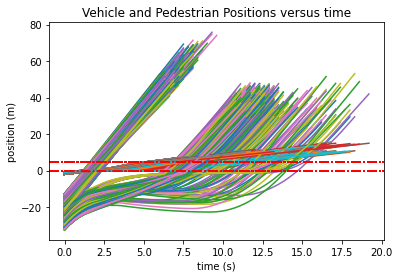

In [98]:
#Positions des agents
t=0
plt.title("Vehicle and Pedestrian Positions versus time")
plt.xlabel("time (s)")
plt.ylabel("position (m)")
j=0
while t+1<len(ep_time):
    t_init=t
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        t+=1
    plt.plot(ep_time[t_init:t],ep_pos_car[t_init:t])#, label="car"+str(j)
    plt.plot(ep_time[t_init:t],ep_pos_ped[t_init:t])
    plt.axhline(y=5, color='r', linestyle='-.')
    plt.axhline(y=0, color='r', linestyle='-.')
    t+=1
    j+=1
_=plt.axhline(y=5, color='r', linestyle='-.')
_=plt.axhline(y=0, color='r', linestyle='-.')
#_=plt.legend()

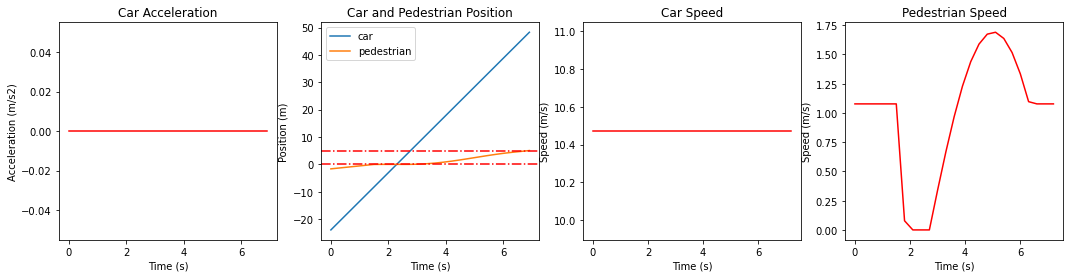

In [99]:
#Showing Vehicle Acceleration Diagram, Vehicle Speed Diagram, Vehicle and Pedestrian Position Diagram
#All three over time in an episode

#t=0
if (t+1>=len(ep_time)):
    t=0
t_init=t
while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
    t+=1
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(18, 4))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.plot(ep_time[t_init:t],ep_action[t_init:t],color='r')

ax2.set_title('Car and Pedestrian Position')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Position (m)")
ax2.plot(ep_time[t_init:t],ep_pos_car[t_init:t],label='car')
ax2.plot(ep_time[t_init:t],ep_pos_ped[t_init:t],label='pedestrian')
ax2.axhline(y=5, color='r', linestyle='-.')
ax2.axhline(y=0, color='r', linestyle='-.')
ax2.legend()

ax3.set_title('Car Speed')
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Speed (m/s)")
ax3.plot(ep_time[t_init:t+1],ep_speed_car[t_init:t+1],color='r')

ax4.set_title('Pedestrian Speed')
ax4.set_xlabel("Time (s)")
ax4.set_ylabel("Speed (m/s)")
ax4.plot(ep_time[t_init:t+1],ep_speed_ped[t_init:t+1],color='r')
t+=1

In [100]:
#Show general information about the final algorithm performance: average speed, CO2 emission, end-time

LDV = pd.read_csv('LDV.csv', sep=';',names=["sp","acc","step","em_name","em_val"])
LDV.pop('step')
m = LDV == 0.0
LDV['acc'] = LDV['acc'].replace(1.27676e-15,0.0)
LDV['acc'] = LDV['acc'].astype(float)
LDV_array = np.array(LDV.values)

def info_co2(states,LDV):
    """
        Evaluate the CO2 emission per episode 
        :param states: state list
        :param LDV: CO2 emission chart
    """
    t=0
    total_emission=[]
    while t+1<len(ep_time):
        t_init=t
        emission_val=[]
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            acc=math.trunc(((states[t,0].item()//0.2)*0.2)*10.)/10.
            speed=math.trunc(((states[t,1].item()//0.5)*0.5)*10.)/10.
            cond=(LDV.sp==speed)&(LDV.acc==acc)&(LDV.em_name=="CO2")
            res=LDV[cond]['em_val'].item() *0.3
            emission_val.append(res)
            t+=1
        total_emission.append(np.sum(np.array(emission_val),axis=0))
        t+=1
    torch_total_emission=np.array(total_emission)
    total_emission_mean=np.mean(torch_total_emission)
    total_emission_std=np.std(torch_total_emission)
    print("\nThe average CO2 emission is {:.2f}mg and its standard deviation is {:.2f} mg".format(total_emission_mean.item(),total_emission_std.item()))
    
def get_average(states,LDV):
    ep_time=states[:,9]
    mean_speed=np.mean(states[:,1])
    sqrt_speed=np.std(states[:,1])
    print("The average car speed is {:.2f} m/s and its standard deviation is {:.2f} m/s".format(mean_speed.item(),sqrt_speed.item()))
    mean_acc=np.mean(states[:,0])
    sqrt_acc=np.std(states[:,0])
    print("\nThe average car acceleration is {:.2f} m/s2 and its standard deviation is {:.2f} m/s2".format(mean_acc.item(),sqrt_acc.item()))
    mean_speed_p=np.mean(states[:,3])
    sqrt_speed_p=np.std(states[:,3])
    print("\nThe average pedestrian speed is {:.2f} m/s and its standard deviation is {:.2f} m/s".format(mean_speed_p.item(),sqrt_speed_p.item()))    
    mean_reward=np.mean(ep_reward)
    std_reward=np.std(ep_reward)
    print("\nThe average reward is {:.2f} and its standard deviation is {:.2f}".format(mean_reward.item(),std_reward.item()))
    info_co2(states,LDV) #CO2 info
    temps=[]
    t=0
    while t+1<len(ep_time):
        temps_i=np.array([0.,0.]) #respectively: end-time car/pedestrian
        t_init=t
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            if(states[t,2]<0.0 and states[t+1,2]>=0.0):
                temps_i[0]=(t-t_init)*0.3
            if(states[t,4]<5.0 and states[t+1,4]>=5.0):
                temps_i[1]=(t-t_init)*0.3
            t+=1
        if(temps_i[1]==0.0):
            temps_i[1]=(t-t_init)*0.3
        temps.append([(t-t_init)*0.3,temps_i[0],temps_i[1]])
        t+=1
    total_temps=np.array([temps]).reshape((-1,3))
    total_temps_mean=np.mean(total_temps,axis=0)
    print("\n Average End-times:")
    print("Total: {:.2f} s".format(total_temps_mean[0].item()))
    print("Car: {:.2f} s".format(total_temps_mean[1].item()))
    print("Pedestrian: {:.2f} s".format(total_temps_mean[2].item()))
get_average(states,LDV)

The average car speed is 7.19 m/s and its standard deviation is 3.39 m/s

The average car acceleration is -0.00 m/s2 and its standard deviation is 1.53 m/s2

The average pedestrian speed is 0.99 m/s and its standard deviation is 0.38 m/s

The average reward is -1.15 and its standard deviation is 2.85

The average CO2 emission is 21636.05mg and its standard deviation is 6992.73 mg

 Average End-times:
Total: 9.62 s
Car: 4.55 s
Pedestrian: 6.60 s


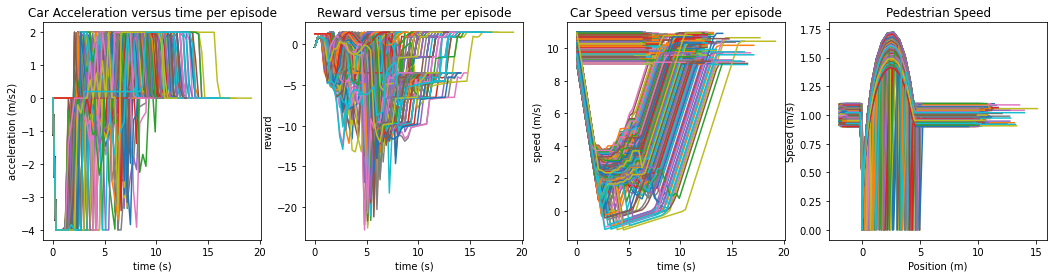

In [76]:
#Accélération, Reward, Vitesse de la voiture
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(18, 4))

t=0
ax1.set_title("Car Acceleration versus time per episode")
ax1.set_xlabel("time (s)")
ax1.set_ylabel("acceleration (m/s2)")

ax2.set_title("Reward versus time per episode")
ax2.set_xlabel("time (s)")
ax2.set_ylabel("reward")

ax3.set_title("Car Speed versus time per episode")
ax3.set_xlabel("time (s)")
ax3.set_ylabel("speed (m/s)")

ax4.set_title('Pedestrian Speed')
ax4.set_xlabel("Position (m)")
ax4.set_ylabel("Speed (m/s)")
while t+1<len(ep_time):
    t_init=t
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        t+=1
    ax1.plot(ep_time[t_init:t],ep_action[t_init:t])
    ax2.plot(ep_time[t_init:t],ep_reward[t_init:t])
    ax3.plot(ep_time[t_init:t],ep_speed_car[t_init:t])
    ax4.plot(states[t_init:t,4],states[t_init:t,3])
    t+=1


In [101]:
#6) Edges Cases: 
#decided, change_speed, stops (with imminent decision)
#decided cases do not work because of the reward structure
problem = "Crosswalk_test-v0"
u_b = [2.0, 11.0, -20.0, 1.1, -1.0]
l_b = [-4.0, 9.0, -25.0, 0.9, -1.5]

env = gym.make(problem,dt=0.3,Vm=2.5,lower_bounds=l_b, upper_bounds=u_b,simulation="sin",initial_mode="stops")

# Initialize the algorithm
num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
num_algo=1
u_b2=[200.0,15.0,2.0]
l_b2=[-45.0,0.0,-4.0]
algo=Algo_QP(Model_QP, env, num_algo= num_algo, num_states=num_states, num_actions=num_actions,l_b=l_b2, u_b=u_b2, tau=1.0)


C:\Users\abrunoud\Anaconda3\envs\ppotest\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [102]:
#Stock an evaluation sample
states, actions, rewards = algo.evaluate(1000)
states=np.array(states)
ep_action=states[:,0]
ep_speed_car=states[:,1]
ep_pos_car=states[:,2]
ep_speed_ped=states[:,3]
ep_pos_ped=states[:,4]
ep_time=states[:,9]
ep_reward=rewards
t=0

Episode * 0 * Avg Reward is ==> -4.179091128990617 And Number of steps is ==> 0
Episode * 1 * Avg Reward is ==> 1.44947341358187 And Number of steps is ==> 1
Episode * 2 * Avg Reward is ==> -4.240671485345027 And Number of steps is ==> 2
Episode * 3 * Avg Reward is ==> 1.4999999999999987 And Number of steps is ==> 3
Episode * 4 * Avg Reward is ==> -4.874196867339835 And Number of steps is ==> 4
Episode * 5 * Avg Reward is ==> -4.1536226173354915 And Number of steps is ==> 5
Episode * 6 * Avg Reward is ==> 1.5 And Number of steps is ==> 6
Episode * 7 * Avg Reward is ==> 0.7887292605000132 And Number of steps is ==> 7
Episode * 8 * Avg Reward is ==> -5.385749254954574 And Number of steps is ==> 8
Episode * 9 * Avg Reward is ==> -6.105200851579459 And Number of steps is ==> 9
Episode * 10 * Avg Reward is ==> -4.137759678358221 And Number of steps is ==> 10
Episode * 11 * Avg Reward is ==> 1.0899600594940897 And Number of steps is ==> 11
Episode * 12 * Avg Reward is ==> -4.2043622651191175

Episode * 103 * Avg Reward is ==> -4.252492765901861 And Number of steps is ==> 103
Episode * 104 * Avg Reward is ==> -3.6551705756300192 And Number of steps is ==> 104
Episode * 105 * Avg Reward is ==> -5.311745320588851 And Number of steps is ==> 105
Episode * 106 * Avg Reward is ==> -5.659003845931749 And Number of steps is ==> 106
Episode * 107 * Avg Reward is ==> 0.7886394451383264 And Number of steps is ==> 107
Episode * 108 * Avg Reward is ==> -4.232673330933061 And Number of steps is ==> 108
Episode * 109 * Avg Reward is ==> -4.236045384997735 And Number of steps is ==> 109
Episode * 110 * Avg Reward is ==> 0.7388981856983181 And Number of steps is ==> 110
Episode * 111 * Avg Reward is ==> -4.21022339102861 And Number of steps is ==> 111
Episode * 112 * Avg Reward is ==> -4.069965472803768 And Number of steps is ==> 112
Episode * 113 * Avg Reward is ==> 1.4483118198534903 And Number of steps is ==> 113
Episode * 114 * Avg Reward is ==> 0.7404375611544473 And Number of steps is 

Episode * 206 * Avg Reward is ==> -5.311785400483712 And Number of steps is ==> 206
Episode * 207 * Avg Reward is ==> 0.4331360326435504 And Number of steps is ==> 207
Episode * 208 * Avg Reward is ==> 1.4999999999999998 And Number of steps is ==> 208
Episode * 209 * Avg Reward is ==> -6.523046553018408 And Number of steps is ==> 209
Episode * 210 * Avg Reward is ==> -4.235829628793637 And Number of steps is ==> 210
Episode * 211 * Avg Reward is ==> -5.2721779617898195 And Number of steps is ==> 211
Episode * 212 * Avg Reward is ==> -4.259485071060061 And Number of steps is ==> 212
Episode * 213 * Avg Reward is ==> -3.6557840324873565 And Number of steps is ==> 213
Episode * 214 * Avg Reward is ==> 0.7403188784701438 And Number of steps is ==> 214
Episode * 215 * Avg Reward is ==> 0.12524935123518458 And Number of steps is ==> 215
Episode * 216 * Avg Reward is ==> -4.075583499873238 And Number of steps is ==> 216
Episode * 217 * Avg Reward is ==> -3.655280158456951 And Number of steps 

Episode * 308 * Avg Reward is ==> 0.43098626624984027 And Number of steps is ==> 308
Episode * 309 * Avg Reward is ==> -5.235956951770342 And Number of steps is ==> 309
Episode * 310 * Avg Reward is ==> -6.07118669060326 And Number of steps is ==> 310
Episode * 311 * Avg Reward is ==> -4.033595089326733 And Number of steps is ==> 311
Episode * 312 * Avg Reward is ==> 0.12336288610748332 And Number of steps is ==> 312
Episode * 313 * Avg Reward is ==> -4.2059075980303415 And Number of steps is ==> 313
Episode * 314 * Avg Reward is ==> 1.4999999999999993 And Number of steps is ==> 314
Episode * 315 * Avg Reward is ==> -6.090604628494829 And Number of steps is ==> 315
Episode * 316 * Avg Reward is ==> -4.1357343762676075 And Number of steps is ==> 316
Episode * 317 * Avg Reward is ==> -5.58241320025032 And Number of steps is ==> 317
Episode * 318 * Avg Reward is ==> -3.656658562385153 And Number of steps is ==> 318
Episode * 319 * Avg Reward is ==> -4.164440367667735 And Number of steps i

Episode * 408 * Avg Reward is ==> -4.190486380241365 And Number of steps is ==> 408
Episode * 409 * Avg Reward is ==> -4.894761918720041 And Number of steps is ==> 409
Episode * 410 * Avg Reward is ==> 1.0425944985063726 And Number of steps is ==> 410
Episode * 411 * Avg Reward is ==> -0.1907977432363735 And Number of steps is ==> 411
Episode * 412 * Avg Reward is ==> 0.4825469285025606 And Number of steps is ==> 412
Episode * 413 * Avg Reward is ==> 0.12392829795072098 And Number of steps is ==> 413
Episode * 414 * Avg Reward is ==> 1.0438452508849045 And Number of steps is ==> 414
Episode * 415 * Avg Reward is ==> 0.7398452370945066 And Number of steps is ==> 415
Episode * 416 * Avg Reward is ==> -4.187012800350075 And Number of steps is ==> 416
Episode * 417 * Avg Reward is ==> -4.166453656294901 And Number of steps is ==> 417
Episode * 418 * Avg Reward is ==> -5.275362101196767 And Number of steps is ==> 418
Episode * 419 * Avg Reward is ==> -4.1613517211106235 And Number of steps 

Episode * 506 * Avg Reward is ==> 1.4455943887462104 And Number of steps is ==> 506
Episode * 507 * Avg Reward is ==> -4.675377531389695 And Number of steps is ==> 507
Episode * 508 * Avg Reward is ==> 1.4495093194324158 And Number of steps is ==> 508
Episode * 509 * Avg Reward is ==> 0.12191884713754834 And Number of steps is ==> 509
Episode * 510 * Avg Reward is ==> 1.0428658030475078 And Number of steps is ==> 510
Episode * 511 * Avg Reward is ==> -6.062342307532996 And Number of steps is ==> 511
Episode * 512 * Avg Reward is ==> 0.43595563751603167 And Number of steps is ==> 512
Episode * 513 * Avg Reward is ==> 0.4345371960614669 And Number of steps is ==> 513
Episode * 514 * Avg Reward is ==> -0.19549208369086735 And Number of steps is ==> 514
Episode * 515 * Avg Reward is ==> 1.4999999999999996 And Number of steps is ==> 515
Episode * 516 * Avg Reward is ==> -4.5825457961818 And Number of steps is ==> 516
Episode * 517 * Avg Reward is ==> 1.5 And Number of steps is ==> 517
Episo

Episode * 610 * Avg Reward is ==> 1.3445871802973528 And Number of steps is ==> 610
Episode * 611 * Avg Reward is ==> 0.788277223248563 And Number of steps is ==> 611
Episode * 612 * Avg Reward is ==> 1.4999999999999987 And Number of steps is ==> 612
Episode * 613 * Avg Reward is ==> -0.19229809315883334 And Number of steps is ==> 613
Episode * 614 * Avg Reward is ==> 1.0430947877643402 And Number of steps is ==> 614
Episode * 615 * Avg Reward is ==> 0.7404609989104917 And Number of steps is ==> 615
Episode * 616 * Avg Reward is ==> 0.43427839169408244 And Number of steps is ==> 616
Episode * 617 * Avg Reward is ==> -4.180002559562122 And Number of steps is ==> 617
Episode * 618 * Avg Reward is ==> 1.0435573532378668 And Number of steps is ==> 618
Episode * 619 * Avg Reward is ==> 0.12461582328838143 And Number of steps is ==> 619
Episode * 620 * Avg Reward is ==> -4.143249647944326 And Number of steps is ==> 620
Episode * 621 * Avg Reward is ==> 0.4279985452063113 And Number of steps 

Episode * 708 * Avg Reward is ==> -4.975707627476883 And Number of steps is ==> 708
Episode * 709 * Avg Reward is ==> -4.618102765134793 And Number of steps is ==> 709
Episode * 710 * Avg Reward is ==> 0.7407845422355706 And Number of steps is ==> 710
Episode * 711 * Avg Reward is ==> -0.18666889451297836 And Number of steps is ==> 711
Episode * 712 * Avg Reward is ==> -4.210491089618737 And Number of steps is ==> 712
Episode * 713 * Avg Reward is ==> -4.220350884159125 And Number of steps is ==> 713
Episode * 714 * Avg Reward is ==> -4.255478861693722 And Number of steps is ==> 714
Episode * 715 * Avg Reward is ==> -4.227053414281892 And Number of steps is ==> 715
Episode * 716 * Avg Reward is ==> -4.21767633980134 And Number of steps is ==> 716
Episode * 717 * Avg Reward is ==> 1.0433460902326408 And Number of steps is ==> 717
Episode * 718 * Avg Reward is ==> 1.499999999999997 And Number of steps is ==> 718
Episode * 719 * Avg Reward is ==> -4.666630050172989 And Number of steps is 

Episode * 812 * Avg Reward is ==> 0.12275539384297707 And Number of steps is ==> 812
Episode * 813 * Avg Reward is ==> 0.7409151626820716 And Number of steps is ==> 813
Episode * 814 * Avg Reward is ==> 1.4489460559643246 And Number of steps is ==> 814
Episode * 815 * Avg Reward is ==> -4.173290923303717 And Number of steps is ==> 815
Episode * 816 * Avg Reward is ==> -5.424852520761583 And Number of steps is ==> 816
Episode * 817 * Avg Reward is ==> -4.205397482999735 And Number of steps is ==> 817
Episode * 818 * Avg Reward is ==> 0.17367089295679944 And Number of steps is ==> 818
Episode * 819 * Avg Reward is ==> 1.5 And Number of steps is ==> 819
Episode * 820 * Avg Reward is ==> 1.4498422651272205 And Number of steps is ==> 820
Episode * 821 * Avg Reward is ==> -4.173502744852127 And Number of steps is ==> 821
Episode * 822 * Avg Reward is ==> 0.4338334082138774 And Number of steps is ==> 822
Episode * 823 * Avg Reward is ==> -5.363126876594476 And Number of steps is ==> 823
Episo

Episode * 917 * Avg Reward is ==> -5.189258476423997 And Number of steps is ==> 917
Episode * 918 * Avg Reward is ==> 1.0428744040330835 And Number of steps is ==> 918
Episode * 919 * Avg Reward is ==> 1.0419644826516954 And Number of steps is ==> 919
Episode * 920 * Avg Reward is ==> -4.2284142607869 And Number of steps is ==> 920
Episode * 921 * Avg Reward is ==> -0.45632610412906727 And Number of steps is ==> 921
Episode * 922 * Avg Reward is ==> -4.037822486694155 And Number of steps is ==> 922
Episode * 923 * Avg Reward is ==> 0.7405143530159752 And Number of steps is ==> 923
Episode * 924 * Avg Reward is ==> 1.0437452609448026 And Number of steps is ==> 924
Episode * 925 * Avg Reward is ==> -6.019669016277048 And Number of steps is ==> 925
Episode * 926 * Avg Reward is ==> 1.0906978558829044 And Number of steps is ==> 926
Episode * 927 * Avg Reward is ==> 1.0430863138301225 And Number of steps is ==> 927
Episode * 928 * Avg Reward is ==> -5.6505072175532325 And Number of steps is

In [107]:
#Show general information about the final algorithm performance: average speed, CO2 emission, end-time

LDV = pd.read_csv('LDV.csv', sep=';',names=["sp","acc","step","em_name","em_val"])
LDV.pop('step')
m = LDV == 0.0
LDV['acc'] = LDV['acc'].replace(1.27676e-15,0.0)
LDV['acc'] = LDV['acc'].astype(float)
LDV_array = np.array(LDV.values)

def info_co2(states,LDV):
    """
        Evaluate the CO2 emission per episode 
        :param states: state list
        :param LDV: CO2 emission chart
    """
    t=0
    total_emission=[]
    while t+1<len(ep_time):
        t_init=t
        emission_val=[]
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            acc=math.trunc(((states[t,0].item()//0.2)*0.2)*10.)/10.
            speed=math.trunc(((states[t,1].item()//0.5)*0.5)*10.)/10.
            cond=(LDV.sp==speed)&(LDV.acc==acc)&(LDV.em_name=="CO2")
            res=LDV[cond]['em_val'].item() *0.3
            emission_val.append(res)
            t+=1
        total_emission.append(np.sum(np.array(emission_val),axis=0))
        t+=1
    torch_total_emission=np.array(total_emission)
    total_emission_mean=np.mean(torch_total_emission)
    total_emission_std=np.std(torch_total_emission)
    print("\nThe average CO2 emission is {:.2f}mg and its standard deviation is {:.2f} mg".format(total_emission_mean.item(),total_emission_std.item()))
    
def get_average(states,LDV):
    ep_time=states[:,9]
    mean_speed=np.mean(states[:,1])
    sqrt_speed=np.std(states[:,1])
    print("The average car speed is {:.2f} m/s and its standard deviation is {:.2f} m/s".format(mean_speed.item(),sqrt_speed.item()))
    mean_acc=np.mean(states[:,0])
    sqrt_acc=np.std(states[:,0])
    print("\nThe average car acceleration is {:.2f} m/s2 and its standard deviation is {:.2f} m/s2".format(mean_acc.item(),sqrt_acc.item()))
    mean_speed_p=np.mean(states[:,3])
    sqrt_speed_p=np.std(states[:,3])
    print("\nThe average pedestrian speed is {:.2f} m/s and its standard deviation is {:.2f} m/s".format(mean_speed_p.item(),sqrt_speed_p.item()))    
    mean_reward=np.mean(ep_reward)
    std_reward=np.std(ep_reward)
    print("\nThe average reward is {:.2f} and its standard deviation is {:.2f}".format(mean_reward.item(),std_reward.item()))
    info_co2(states,LDV) #CO2 info
    temps=[]
    t=0
    while t+1<len(ep_time):
        temps_i=np.array([0.,0.]) #respectively: end-time car/pedestrian
        t_init=t
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            if(states[t,2]<0.0 and states[t+1,2]>=0.0):
                temps_i[0]=(t-t_init)*0.3
            if(states[t,4]<5.0 and states[t+1,4]>=5.0):
                temps_i[1]=(t-t_init)*0.3
            t+=1
        if(temps_i[1]==0.0):
            temps_i[1]=(t-t_init)*0.3
        temps.append([(t-t_init)*0.3,temps_i[0],temps_i[1]])
        t+=1
    total_temps=np.array([temps]).reshape((-1,3))
    total_temps_mean=np.mean(total_temps,axis=0)
    print("\n Average End-times:")
    print("Total: {:.2f} s".format(total_temps_mean[0].item()))
    print("Car: {:.2f} s".format(total_temps_mean[1].item()))
    print("Pedestrian: {:.2f} s".format(total_temps_mean[2].item()))
get_average(states,LDV)

The average car speed is 6.66 m/s and its standard deviation is 3.99 m/s

The average car acceleration is -0.00 m/s2 and its standard deviation is 1.55 m/s2

The average pedestrian speed is 0.87 m/s and its standard deviation is 0.48 m/s

The average reward is -4.37 and its standard deviation is 10.74

The average CO2 emission is 23743.35mg and its standard deviation is 7364.08 mg

 Average End-times:
Total: 10.79 s
Car: 5.46 s
Pedestrian: 7.69 s


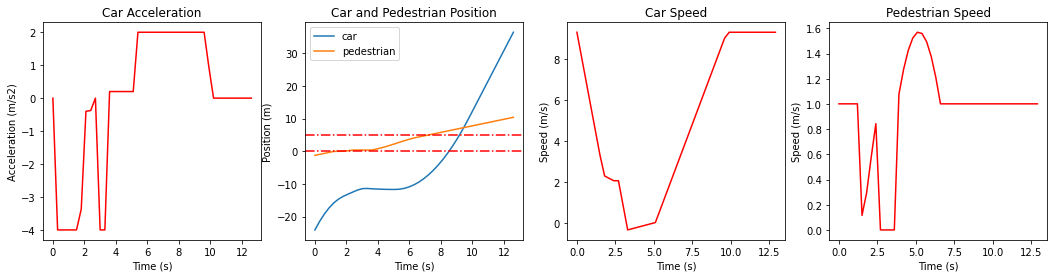

In [111]:
#Showing Vehicle Acceleration Diagram, Vehicle Speed Diagram, Vehicle and Pedestrian Position Diagram
#All three over time in an episode

#t=0
if (t+1>=len(ep_time)):
    t=0
t_init=t
while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
    t+=1
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(18, 4))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.plot(ep_time[t_init:t],ep_action[t_init:t],color='r')

ax2.set_title('Car and Pedestrian Position')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Position (m)")
ax2.plot(ep_time[t_init:t],ep_pos_car[t_init:t],label='car')
ax2.plot(ep_time[t_init:t],ep_pos_ped[t_init:t],label='pedestrian')
ax2.axhline(y=5, color='r', linestyle='-.')
ax2.axhline(y=0, color='r', linestyle='-.')
ax2.legend()

ax3.set_title('Car Speed')
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Speed (m/s)")
ax3.plot(ep_time[t_init:t+1],ep_speed_car[t_init:t+1],color='r')

ax4.set_title('Pedestrian Speed')
ax4.set_xlabel("Time (s)")
ax4.set_ylabel("Speed (m/s)")
ax4.plot(ep_time[t_init:t+1],ep_speed_ped[t_init:t+1],color='r')
t+=1